#### **Import Libraries**

In [10]:
import os 
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from sklearn.model_selection import train_test_split
from datasets import Dataset, DatasetDict
from tqdm import tqdm
import numpy as np 
import random 
import math
from itertools import chain
from IPython.display import display, Markdown
import textwrap
import tiktoken
import csv
import time 
import pandas as pd 
import torch
from datasets import Dataset
from torch.utils.data import DataLoader
import transformers
from transformers import DataCollatorWithPadding
from llmft.train import EncoderTrainer, EarlyStopping
from llmft.metrics import compute_recall
from llmft.losses import FocalLoss
from llmft.utils import predict
import seaborn as sns 
import jax 
import jax.numpy as jnp 

#### **Set Up Paths**

In [11]:
data_csv = './../../../toy-data/exp2/results/llms_combined_results.csv'

#### **Set Up Plotting**

In [12]:
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import rcParams
rcParams['image.interpolation'] = 'nearest'
rcParams['image.cmap'] = 'viridis'
rcParams['axes.grid'] = False
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
plt.style.use('seaborn-v0_8-dark-palette')

from matplotlib import font_manager 
locations = './../../../styles/Newsreader'
font_files = font_manager.findSystemFonts(fontpaths=locations)
print(locations)
print(font_files[0])
for f in font_files: 
    font_manager.fontManager.addfont(f)
plt.rcParams["font.family"] = "Newsreader"

./../../../styles/Newsreader
/home/ubuntu/llmft/styles/Newsreader/Newsreader-Italic-VariableFont_opsz,wght.ttf


In [13]:
def process_dataframe(df):
    # Limit to the first 20 observations
    df = df.head(20)
    
    # Drop rows where any column has an absolute value greater than 2
    df = df[df.apply(lambda x: (x.abs() <= 2).all(), axis=1)]
    return df

In [14]:
version = 4
sample_size = 1000


In [15]:
noise = False
df_linear = pd.read_csv(f'./../../../toy-data/exp2/results/linear_{version}_{noise}.csv')
df_oracle = pd.read_csv(f'./../../../toy-data/exp2/results/oracle_{version}_{noise}.csv')
df_llms = pd.read_csv(f'./../../../toy-data/exp2/results/llms_{version}_{sample_size}_{noise}.csv')

noise = True
df_linear_noise = pd.read_csv(f'./../../../toy-data/exp2/results/linear_{version}_{noise}.csv')
df_oracle_noise = pd.read_csv(f'./../../../toy-data/exp2/results/oracle_{version}_{noise}.csv')
df_llms_noise = pd.read_csv(f'./../../../toy-data/exp2/results/llms_{version}_{sample_size}_{noise}.csv')

# Assuming you've already loaded the data as shown previously and `version`, `sample_size` are defined
df_linear = process_dataframe(df_linear)
df_oracle = process_dataframe(df_oracle)
df_llms = process_dataframe(df_llms)

df_linear_noise = process_dataframe(df_linear_noise)
df_oracle_noise = process_dataframe(df_oracle_noise)
df_llms_noise = process_dataframe(df_llms_noise)


In [16]:
print(np.std(df_oracle.values))
print(np.std(df_llms.values))
print(np.std(df_linear.values))


0.020957326627275917
0.01677215909207518
0.05723667782096645


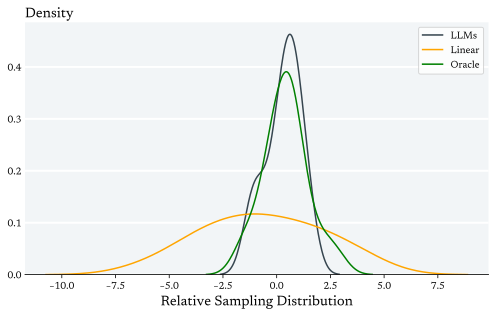

In [17]:
fig = plt.figure(dpi=300, tight_layout=True, figsize=(7, 4.5))
ax = plt.axes(facecolor=(.95, .96, .97))

# Set visibility of some spines
for key in 'left', 'right', 'top':
    ax.spines[key].set_visible(False)

# Add text to the axes
ax.text(0., 1.02, s='Density', transform=ax.transAxes, size=14)

# Set Y-axis tick parameters and grid
ax.yaxis.set_tick_params(length=0)
ax.yaxis.grid(True, color='white', linewidth=2)
ax.set_axisbelow(True)


baseline = np.std(df_oracle['Estimate'])
target = 1.0
sns.kdeplot((df_llms['Estimate']-target)/baseline, color='#36454F', label='LLMs')
sns.kdeplot((df_linear['Estimate']-target)/baseline, color="orange", label='Linear')
sns.kdeplot((df_oracle['Estimate']-target)/baseline, color="green", label='Oracle')
plt.ylabel('')
plt.xlabel('Relative Sampling Distribution', size=14)
plt.legend()
plt.show()

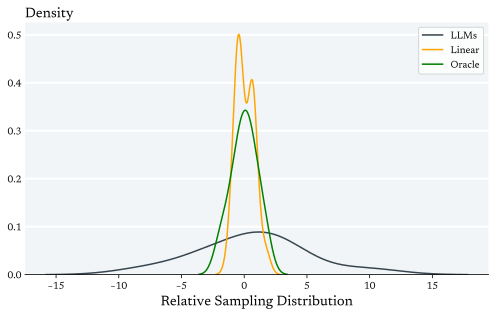

In [18]:
fig = plt.figure(dpi=300, tight_layout=True, figsize=(7, 4.5))
ax = plt.axes(facecolor=(.95, .96, .97))

# Set visibility of some spines
for key in 'left', 'right', 'top':
    ax.spines[key].set_visible(False)

# Add text to the axes
ax.text(0., 1.02, s='Density', transform=ax.transAxes, size=14)

# Set Y-axis tick parameters and grid
ax.yaxis.set_tick_params(length=0)
ax.yaxis.grid(True, color='white', linewidth=2)
ax.set_axisbelow(True)


baseline_noise = np.std(df_oracle_noise['Estimate'])
target = 1.0
sns.kdeplot((df_llms_noise['Estimate']-target)/baseline_noise, color='#36454F', label='LLMs')
sns.kdeplot((df_linear_noise['Estimate']-target)/baseline_noise, color="orange", label='Linear')
sns.kdeplot((df_oracle_noise['Estimate']-target)/baseline_noise, color="green", label='Oracle')
plt.ylabel('')
plt.xlabel('Relative Sampling Distribution', size=14)
plt.legend()
plt.show()